In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import os
# suppress tf informational and warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import gc

import time

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras import backend as K

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn import metrics

import category_encoders as ce

RANDOM_STATE = 73
keras.utils.set_random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [3]:
ls -lh '/kaggle/input/playground-series-s4e7'

total 1.2G
-rw-r--r-- 1 nobody nogroup  96M Jun 30 23:32 sample_submission.csv
-rw-r--r-- 1 nobody nogroup 414M Jun 30 23:32 test.csv
-rw-r--r-- 1 nobody nogroup 633M Jun 30 23:32 train.csv


In [3]:
%%time
train_data = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

CPU times: user 24 s, sys: 4.21 s, total: 28.2 s
Wall time: 35.6 s


In [6]:
from IPython.display import display_html
df1_styler = train_data.head().style.set_table_attributes("style='display:inline'").set_caption('Head Train Data').background_gradient(cmap='plasma')
df2_styler = test_data.head().style.set_table_attributes("style='display:inline'").set_caption('Head Test Data').background_gradient(cmap='plasma')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

Head Train Data 
 
 
   
 id 
 Gender 
 Age 
 Driving_License 
 Region_Code 
 Previously_Insured 
 Vehicle_Age 
 Vehicle_Damage 
 Annual_Premium 
 Policy_Sales_Channel 
 Vintage 
 Response 
 
 
 
 
 0 
 0 
 Male 
 21 
 1 
 35.000000 
 0 
 1-2 Year 
 Yes 
 65101.000000 
 124.000000 
 187 
 0 
 
 
 1 
 1 
 Male 
 43 
 1 
 28.000000 
 0 
 > 2 Years 
 Yes 
 58911.000000 
 26.000000 
 288 
 1 
 
 
 2 
 2 
 Female 
 25 
 1 
 14.000000 
 1 
 < 1 Year 
 No 
 38043.000000 
 152.000000 
 254 
 0 
 
 
 3 
 3 
 Female 
 35 
 1 
 1.000000 
 0 
 1-2 Year 
 Yes 
 2630.000000 
 156.000000 
 76 
 0 
 
 
 4 
 4 
 Female 
 36 
 1 
 15.000000 
 1 
 1-2 Year 
 No 
 31951.000000 
 152.000000 
 294 
 0 
 
 
 

 
 Head Test Data 
 
 
   
 id 
 Gender 
 Age 
 Driving_License 
 Region_Code 
 Previously_Insured 
 Vehicle_Age 
 Vehicle_Damage 
 Annual_Premium 
 Policy_Sales_Channel 
 Vintage 
 
 
 
 
 0 
 11504798 
 Female 
 20 
 1 
 47.000000 
 0 
 < 1 Year 
 No 
 2630.000000 
 160.000000 
 228 
 
 
 1 
 11504799 
 Male 
 47 
 1 
 28.000000 
 0 
 1-2 Year 
 Yes 
 37483.000000 
 124.000000 
 123 
 
 
 2 
 11504800 
 Male 
 47 
 1 
 43.000000 
 0 
 1-2 Year 
 Yes 
 2630.000000 
 26.000000 
 271 
 
 
 3 
 11504801 
 Female 
 22 
 1 
 47.000000 
 1 
 < 1 Year 
 No 
 24502.000000 
 152.000000 
 115 
 
 
 4 
 11504802 
 Male 
 51 
 1 
 19.000000 
 0 
 1-2 Year 
 No 
 34115.000000 
 124.000000 
 148

In [7]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [8]:
summary(train_data).style.background_gradient(cmap='plasma')

data shape: (11504798, 12)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.000000,11504798,0.000000,11504797.000000,0,1,2
Gender,object,0,0.000000,2,nan,nan,Male,Male,Female
Age,int64,0,0.000000,66,20.000000,85.000000,21,43,25
Driving_License,int64,0,0.000000,2,0.000000,1.000000,1,1,1
Region_Code,float64,0,0.000000,54,0.000000,52.000000,35.000000,28.000000,14.000000
Previously_Insured,int64,0,0.000000,2,0.000000,1.000000,0,0,1
Vehicle_Age,object,0,0.000000,3,nan,nan,1-2 Year,> 2 Years,< 1 Year
Vehicle_Damage,object,0,0.000000,2,nan,nan,Yes,Yes,No
Annual_Premium,float64,0,0.000000,51728,2630.000000,540165.000000,65101.000000,58911.000000,38043.000000
Policy_Sales_Channel,float64,0,0.000000,152,1.000000,163.000000,124.000000,26.000000,152.000000


In [9]:
summary(test_data).style.background_gradient(cmap='plasma')

data shape: (7669866, 11)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
id,int64,0,0.000000,7669866,11504798.000000,19174663.000000,11504798,11504799,11504800
Gender,object,0,0.000000,2,nan,nan,Female,Male,Male
Age,int64,0,0.000000,66,20.000000,85.000000,20,47,47
Driving_License,int64,0,0.000000,2,0.000000,1.000000,1,1,1
Region_Code,float64,0,0.000000,53,0.000000,52.000000,47.000000,28.000000,43.000000
Previously_Insured,int64,0,0.000000,2,0.000000,1.000000,0,0,0
Vehicle_Age,object,0,0.000000,3,nan,nan,< 1 Year,1-2 Year,1-2 Year
Vehicle_Damage,object,0,0.000000,2,nan,nan,No,Yes,Yes
Annual_Premium,float64,0,0.000000,50044,2630.000000,540165.000000,2630.000000,37483.000000,2630.000000
Policy_Sales_Channel,float64,0,0.000000,151,1.000000,163.000000,160.000000,124.000000,26.000000


In [10]:
train_data['Response'].value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

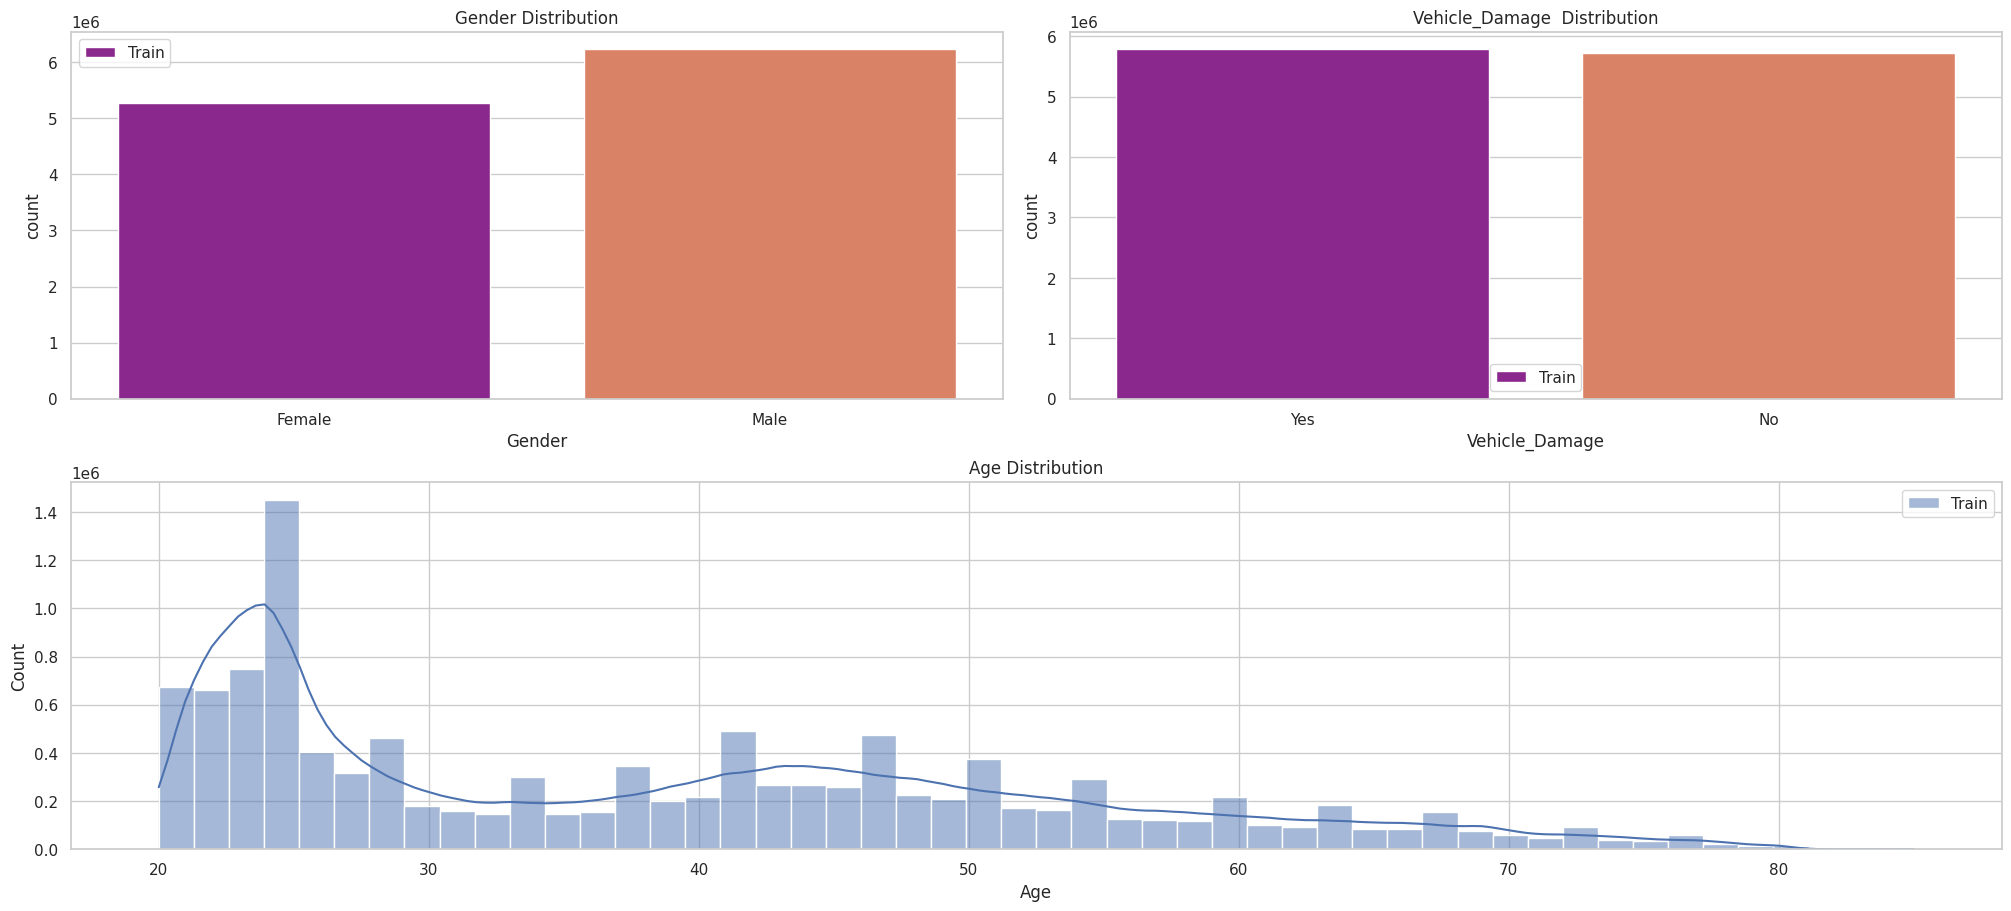

CPU times: user 1min 5s, sys: 2.35 s, total: 1min 8s
Wall time: 1min 6s


In [11]:
%%time
import matplotlib.gridspec as gridspec

sns.set(style="whitegrid")

fig = plt.figure(constrained_layout=True, figsize=(20, 9))
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Gender Distribution')
sns.countplot(x=train_data['Gender'].sort_values(ignore_index=True), ax=ax1, palette='plasma', label='Train')
ax1.legend()

ax2 = fig.add_subplot(grid[0, 2:])
ax2.set_title('Vehicle_Damage  Distribution')
sns.countplot(x=train_data['Vehicle_Damage'], ax=ax2, palette='plasma', label='Train',
              order=train_data['Vehicle_Damage'].value_counts().index)
ax2.legend()

ax3 = fig.add_subplot(grid[1, :])
ax3.set_title('Age Distribution')
sns.histplot(train_data['Age'], kde=True, ax=ax3, bins=50, label='Train', palette='plasma')
ax3.legend()

plt.show()

In [12]:
plasma = ['#F0F921', '#FCB62F', '#F2864A', '#D8586A', '#A31E9A', '#6C00A8', '#290693', '#0D0887']

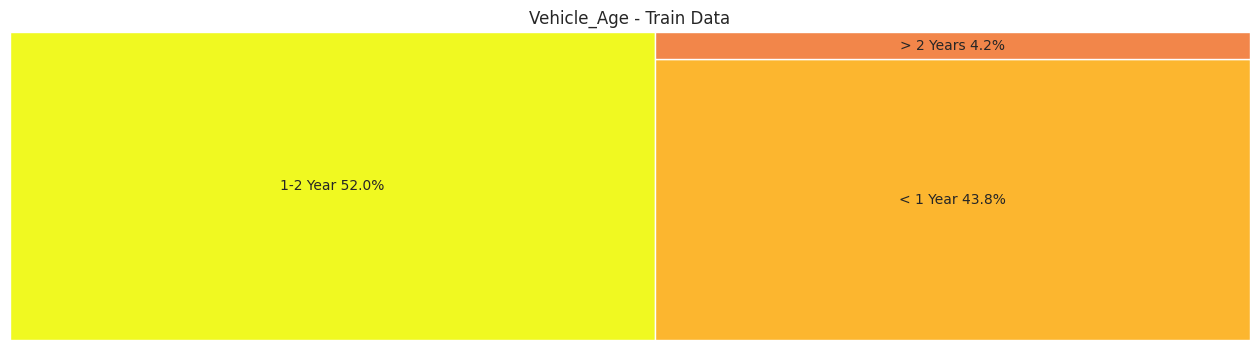

CPU times: user 763 ms, sys: 219 ms, total: 982 ms
Wall time: 739 ms


In [14]:
%%time
import squarify

cntstr = train_data.Vehicle_Age.value_counts().reset_index()
cntstr.columns = ['Vehicle_Age', 'count']

cntstr['percent'] = 100 * cntstr['count'] / cntstr['count'].sum()
cntstr['label'] = cntstr.apply(lambda x: f"{x['Vehicle_Age']} {x['percent']:.1f}%", axis=1)

plt.figure(figsize=(16, 4))
squarify.plot(sizes=cntstr['count'], 
              label=cntstr['label'], 
              color=plasma * (len(cntstr) // len(plasma) + 1),
              text_kwargs={'fontsize':10})

plt.title('Vehicle_Age - Train Data')
plt.axis('off')
plt.show()

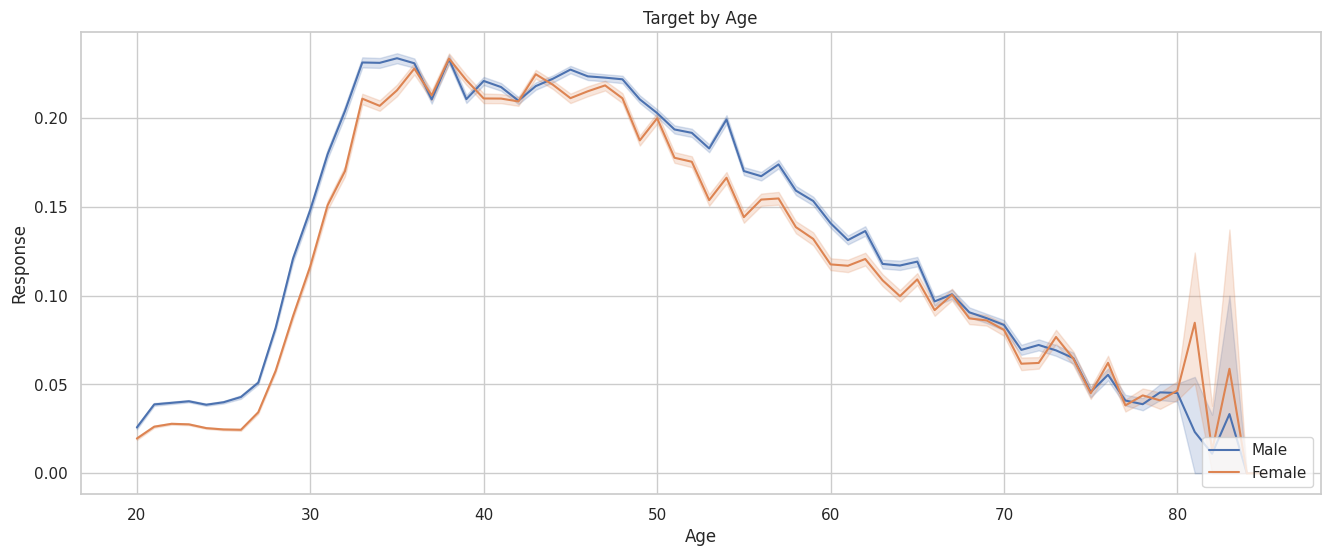

CPU times: user 1min 32s, sys: 1.37 s, total: 1min 34s
Wall time: 1min 33s


In [15]:
%%time
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x='Age',
             y='Response',
             data=train_data,
             hue='Gender')

plt.legend(loc='lower right')

ax.set_title('Target by Age')

plt.show()

In [4]:
def feature_engineering(df):
    #df['Insurance_History'] = df['Previously_Insured'] * df['Vintage']
    df['Vintage_Per_Age'] = df['Vintage'] / df['Age']
    df['Gender_Vehicle_Damage'] = df['Gender'] * df['Vehicle_Damage']
    df['Premium_Per_Vehicle_Age'] = df['Annual_Premium'] / (df['Vehicle_Age'] + 1)
    df['Damage_Probability'] = df['Vehicle_Age'] * df['Vehicle_Damage'] * df['Age']
    #df['Insurance_Region_Interaction'] = df['Previously_Insured'] * df['Region_Code']
    df['Gender_Insurance_Interaction'] = df['Gender'] * df['Previously_Insured']
    #df['Vehicle_Damage_Age_Interaction'] = df['Vehicle_Damage'] * df['Age']
    
    new_features = ['Premium_Per_Vehicle_Age', 'Damage_Probability',
                    'Vintage_Per_Age', 'Gender_Vehicle_Damage', 'Gender_Insurance_Interaction']
    
    return df, new_features

In [ ]:
%%time

TARGET_NAME = 'Response'
cont_features = []    

cat_features = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 
                'Policy_Sales_Channel', 'Region_Code', 'Age', 'Vintage', 'Annual_Premium']

all_data = pd.concat([test_data, train_data])

encode_columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
oe = preprocessing.OrdinalEncoder()
all_data[encode_columns] = oe.fit_transform(all_data[encode_columns]).astype('int')

#oe = preprocessing.OrdinalEncoder()
#all_data[cat_features] = oe.fit_transform(all_data.filter(cat_features)).astype('int')

cat_features_card = {}
for f in cat_features:
    cat_features_card[f] = 1 + all_data[f].max()

all_data, new_features = feature_engineering(all_data)

In [ ]:
train_data = all_data.query(f"not {TARGET_NAME}.isna()")
test_data  = all_data.query(f"{TARGET_NAME}.isna()").drop(columns=[TARGET_NAME])

In [14]:
cont_features = ['Gender', 'Driving_License', 'Vehicle_Damage', 'Previously_Insured', 'Gender_Vehicle_Damage']
cat_features = ['Vehicle_Age', 'Policy_Sales_Channel', 'Region_Code', 'Age', 'Vintage', 'Annual_Premium']
new_features = ['Premium_Per_Vehicle_Age', 'Damage_Probability', 'Vintage_Per_Age', 'Gender_Insurance_Interaction']

features = cont_features + cat_features + new_features

In [6]:
train_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vintage_Per_Age,Gender_Vehicle_Damage,Premium_Per_Vehicle_Age,Damage_Probability,Gender_Insurance_Interaction
0,0,1,21,1,35.0,0,0,1,65101.0,124.0,187,0.0,8.904762,1,65101.0,0,0
1,1,1,43,1,28.0,0,2,1,58911.0,26.0,288,1.0,6.697674,1,19637.0,86,0
2,2,0,25,1,14.0,1,1,0,38043.0,152.0,254,0.0,10.160000,0,19021.5,0,0
3,3,0,35,1,1.0,0,0,1,2630.0,156.0,76,0.0,2.171429,0,2630.0,0,0
4,4,0,36,1,15.0,1,0,0,31951.0,152.0,294,0.0,8.166667,0,31951.0,0,0


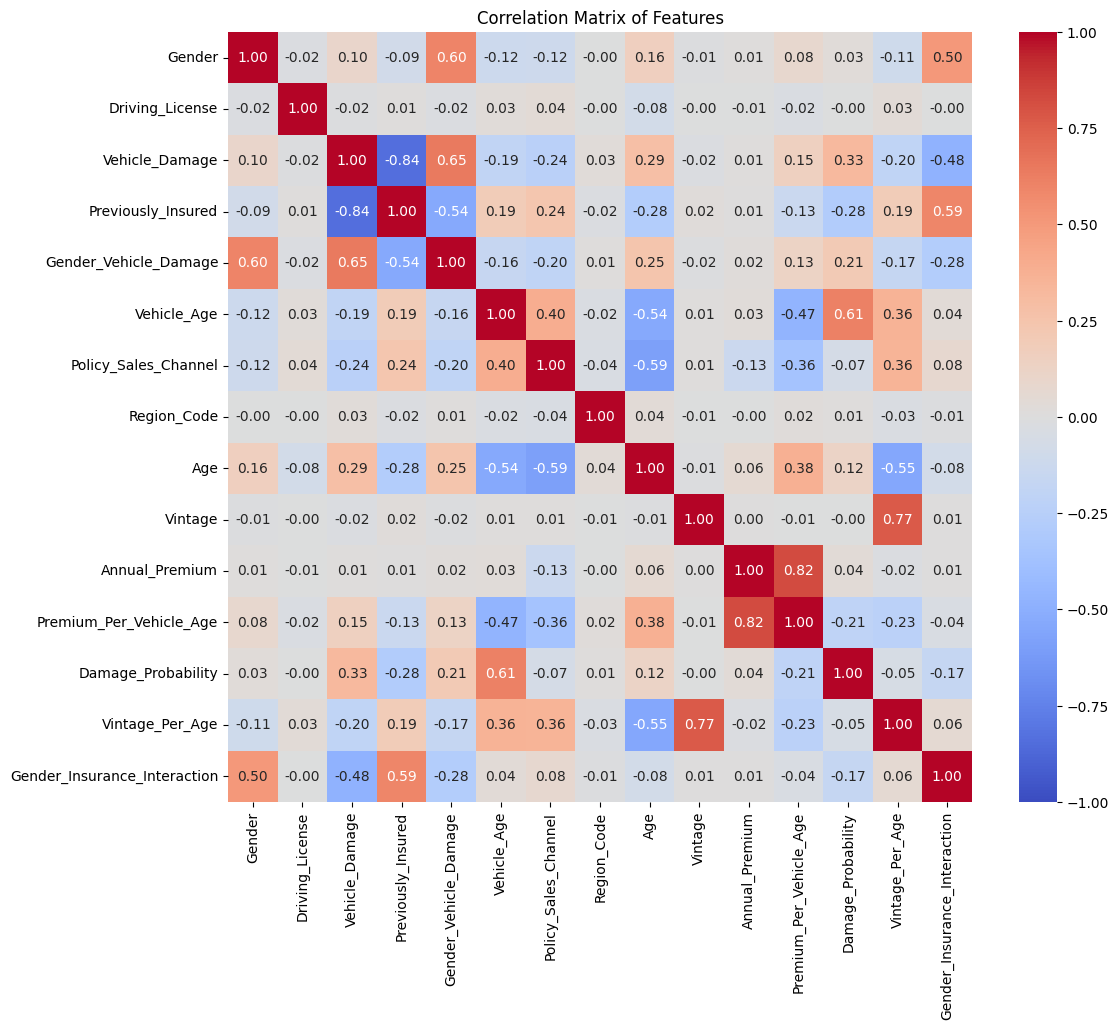

In [15]:
correlation_matrix = train_data[features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

In [21]:
correlation = train_data[features + [TARGET_NAME]].corr()

target_corr = correlation[TARGET_NAME].sort_values(ascending=False)
print("Correlations with the target variable:")
print(target_corr)

Correlations with the target variable:
Response                        1.000000
Vehicle_Damage                  0.359780
Gender_Vehicle_Damage           0.253277
Age                             0.122134
Damage_Probability              0.111028
Premium_Per_Vehicle_Age         0.101984
Gender                          0.055212
Annual_Premium                  0.032261
Region_Code                     0.012816
Driving_License                 0.009197
Vintage                        -0.015177
Vintage_Per_Age                -0.111357
Vehicle_Age                    -0.111630
Policy_Sales_Channel           -0.152733
Gender_Insurance_Interaction   -0.202726
Previously_Insured             -0.345930
Name: Response, dtype: float64


In [ ]:
#print(train_data.isna().sum())

In [17]:
gc.collect()

22146

# Model Architecture

In [18]:
def build_model(cat_features, cont_features, new_features):

    # Define input layers
    cat_inputs = [layers.Input(shape=(1,), name=f'cat{i}') for i in range(len(cat_features))]
    cont_inputs = layers.Input(shape=(len(cont_features) + len(new_features),)) 
    #cont_inputs = layers.Input(shape=(len(cont_features),))
    #cont_inputs_bn = layers.BatchNormalization()(cont_inputs)
                                
    # Embedding layers for categorical inputs
    flat_embeddings = []
    for i, f in enumerate(cat_features):
        input_dim = int(cat_features_card[f])
        output_dim = int(min(64, round(1.6 * input_dim ** .56))) # based on the fastai library
        embedding = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)(cat_inputs[i])
        embedding = layers.SpatialDropout1D(.3)(embedding)
        flat_embeddings.append(layers.Flatten()(embedding))
                                
    concatenated_inputs = layers.Concatenate()(flat_embeddings + [cont_inputs, ])
    concatenated_inputs_bn = layers.BatchNormalization()(concatenated_inputs)

    x = layers.Dense(256, activation='mish')(concatenated_inputs_bn)
    #x = layers.Dropout(.5)(x)
    x = layers.BatchNormalization()(x)
    for units in (128, 64):
        inp = layers.Concatenate()([x, concatenated_inputs_bn])
        x = layers.Dense(units=units, activation='mish')(inp)
        x = layers.Dropout(.3)(x)
        x = layers.BatchNormalization()(x)

    # output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(cat_inputs + [cont_inputs], outputs)

epochs = 4
callbacks = []

# Fit

In [19]:
def fold_logloss(y, preds):
    return metrics.log_loss(y, preds)

def fold_auc(y, preds):
    return metrics.roc_auc_score(y, preds)

cat_idxs= []
cont_idxs = []
for f in cat_features:
    cat_idxs.append([features.index(f)])
for f in cont_features + new_features:
    cont_idxs.append(features.index(f))
    
feature_idxs = cat_idxs + [cont_idxs]

def to_nn_feed(df):
    X = df[feats].values
    result = []
    for f_idx in feature_idxs:
        result.append(X[:, f_idx])
    return result

def fit_fold(tr, vl, ts):

    model = build_model(cat_features, cont_features, new_features)
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1E-4),
        loss='binary_crossentropy',
        metrics=['auc'])

    history = model.fit(
          to_nn_feed(tr), tr[TARGET_NAME],
          validation_data=(to_nn_feed(vl), vl[TARGET_NAME]),
          batch_size=BS,
          epochs=epochs,
          callbacks=callbacks,
          verbose=0
    )

    vl_pred = model.predict(to_nn_feed(vl), verbose=0, batch_size=BS).flatten()
    ts_pred = model.predict(to_nn_feed(ts), verbose=0, batch_size=BS).flatten()
    
    vl_metric = fold_auc(vl[TARGET_NAME], vl_pred)
    return vl_pred, ts_pred, vl_metric

In [20]:
N_FOLDS = 5
BS = 1024
feats = features

vl_preds = np.zeros(len(train_data))
ts_preds = np.zeros(len(test_data))
vl_metrics = []

keras.utils.set_random_seed(RANDOM_STATE)
k_fold = StratifiedKFold(n_splits=N_FOLDS, random_state=RANDOM_STATE, shuffle=True)
for tr_idx, vl_idx in k_fold.split(train_data, train_data[TARGET_NAME]):
    tr = train_data.loc[tr_idx]
    vl = train_data.loc[vl_idx]

    vl_pred, ts_pred, vl_metric = fit_fold(tr, vl, test_data)
    
    print(f'  -- fold auc {vl_metric:2.4f}')
    vl_metrics.append(vl_metric)
    vl_preds[vl_idx] += vl_pred
    ts_preds += ts_pred / N_FOLDS

# overall metric:
vl_metric = fold_auc(
    train_data[TARGET_NAME], vl_preds)
print(f'  ----------- {vl_metric:2.4f}')

W0000 00:00:1721594704.137751     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.8919


W0000 00:00:1721595251.340617     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.8917


W0000 00:00:1721595793.322840     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.8912


W0000 00:00:1721596331.982789     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721596459.405532     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.8917


W0000 00:00:1721596875.651211     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721597002.159208     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  -- fold auc 0.8912
  ----------- 0.8915


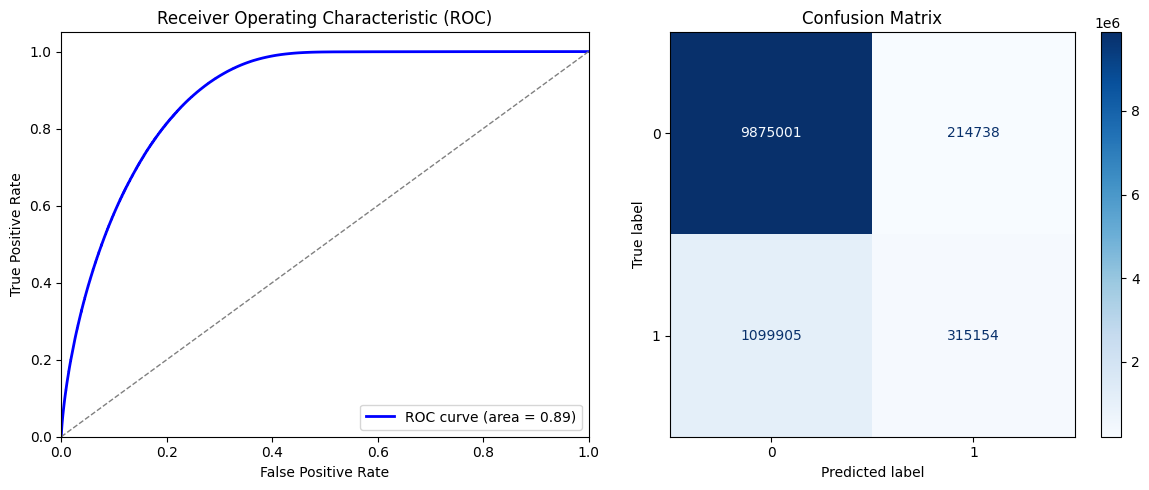

In [22]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

fpr, tpr, _ = roc_curve(train_data[TARGET_NAME], vl_preds)
roc_auc = auc(fpr, tpr)

threshold = 0.5
y_pred_binary = (vl_preds >= threshold).astype(int)
cm = confusion_matrix(train_data[TARGET_NAME], y_pred_binary)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC)')
ax[0].legend(loc='lower right')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[1], cmap='Blues', values_format='d')
ax[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Submission

In [23]:
# oof data
(train_data
    .filter(['id', TARGET_NAME])
    .assign(oof = vl_preds)
    .to_csv('oof.csv', index=False))

pd.read_csv('oof.csv').head()

,id,Response,oof
0,0,0.0,0.298239
1,1,1.0,0.450213
2,2,0.0,0.000027
3,3,0.0,0.142478
4,4,0.0,0.000056


In [24]:
submission_filename = f'submission_{np.mean(vl_metrics):0.4f}.csv'

(test_data
    .assign(**{TARGET_NAME: ts_preds})
    .to_csv(submission_filename, columns=['id', 'Response'], index=False))

In [25]:
pd.read_csv(submission_filename).head()

,id,Response
0,11504798,0.004165
1,11504799,0.601723
2,11504800,0.239094
3,11504801,0.000059
4,11504802,0.115301
